In [ ]:
# Para visualización en notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_context('poster')
mpl.rcParams['figure.figsize'] = (8,6)

# Números y Datos
import numpy as np
import pandas as pd

import networkx as nx
import community.community_louvain as community_louvain

from glob import glob
from pathlib import Path

In [ ]:
!wget -q https://www.dropbox.com/s/eei6gnw10o20mcn/DataSujetos.zip?dl=1 -O DataSujetos.zip
!unzip -q DataSujetos

In [ ]:
filenames_N1 = list(Path('DataSujetos').glob('N1_*.csv'))
filenames_N2 = list(Path('DataSujetos').glob('N2_*.csv'))
filenames_N3 = list(Path('DataSujetos').glob('N3_*.csv'))
filenames_W  = list(Path('DataSujetos').glob('W_*.csv'))

In [ ]:
def subjectmatrix2graphslist(filename, densities):
    """
    Toma un archivo csv con la matriz de input y devuelve una lista de grafos con la densisdad de aristas correspondiente
    """
    
    correlation_matrix = pd.read_csv(filename, header=None)
    n = correlation_matrix.shape[0]
    correlation_matrix -= np.diag(np.ones(n))
    max_links = (n*n-n)//2
    tril_idx = np.tril_indices(n,-1)
    sorted_correlations = sorted(correlation_matrix.values[tril_idx].flatten(),reverse=True)
    
    Gs = []
    for d in densities:
        idx = int(d*max_links)
        threshold = sorted_correlations[idx]
        Gs.append(nx.from_pandas_adjacency(correlation_matrix>=threshold))
        
    return Gs

In [ ]:
densities = np.linspace(0.0001,0.9999,100)
graphs_N1 = {}
for filename in filenames_N1:
    Gs = subjectmatrix2graphslist(filename, densities)
    name = Path(filename).stem
    graphs_N1[name] = Gs
graphs_N2 = {}
for filename in filenames_N2:
    Gs = subjectmatrix2graphslist(filename, densities)
    name = Path(filename).stem
    graphs_N2[name] = Gs
graphs_N3 = {}
for filename in filenames_N3:
    Gs = subjectmatrix2graphslist(filename, densities)
    name = Path(filename).stem
    graphs_N3[name] = Gs
graphs_W = {}
for filename in filenames_W:
    Gs = subjectmatrix2graphslist(filename, densities)
    name = Path(filename).stem
    graphs_W[name] = Gs

In [ ]:
#calcula el z-score de del grado intra-comunidad (zi) para cada nodo del grafo
def zi (df, c_dict):
  df=df.to_numpy()
  kc={}
  #"para cada comunidad i"
  for c in np.unique(list(c_dict.values())):
    nodo_pertenece_c= np.array(list(c_dict.values())) == c
    list_kc_row =[]
    for row in range(len(df)):
      row_elemi=[]
      if nodo_pertenece_c[row]:
        for col in range(len(df)):
          if nodo_pertenece_c[col]:
            #me quedo con elementos que pertenecen a la comunidad
            row_elemi.append(df[row,col]) 
      #calculo grado para ese elemento y lo guardo en una lista
      list_kc_row.append(sum(row_elemi))
    kc[c] = list_kc_row
          
  zi=[]
  for nodo,comunidad in c_dict.items():
    zi.append( ( ( kc[comunidad]-np.mean([x for x in kc[comunidad] if x > 0]) ) /np.std([x for x in kc[comunidad] if x > 0]) ) [nodo-1] )
  return zi

In [ ]:
#grado a módulo Uj, matriz
def KiUj(df,c_dict):
  #df=df.to_numpy()
  lkiUj = {}
  for i in np.unique(list(c_dict.values())):
    lkiUj[i] = list(np.matmul(df,np.array(list(c_dict.values())) == i) ) #no entiendo que hace esto, pero funciona
  return lkiUj

In [ ]:
#calcula el coeficiente de participación (Pi) para cada nodo del grafo
def Pi(df,c_dict):
  df=df.to_numpy()
  Pi=[]
  KiUj_Ac=KiUj(df,c_dict)
  G = nx.from_numpy_matrix(df)
  grado_dict=G.degree
  for nodo in range(len(df)):
    #voy sumando elementos elementos
    elem_sum=0
    for c in np.unique(list(c_dict.values())):
      elem_sum += (KiUj_Ac[c][nodo]/grado_dict[nodo])* (KiUj_Ac[c][nodo]/grado_dict[nodo])

    Pi.append(1-elem_sum)
  return(Pi)



In [ ]:
def dfFinal(graph_dict,densities):
  data_dict = {'subject': [],
       'state'  : [],
       'density': [],
       'Q'      : [],
       'Nc'     : [],
       'Pi_mean' : [],
       'zi_mean' : [],


       'hubs_globales'      : [],
       'hubs_provinciales'     : [],
       'nodos_conectores'      : [],
       'nodos_provinciales'     : []     
       }
  for subject,Gs in graph_dict.items():
    for i,d in enumerate(densities):
      louvain_partition = community_louvain.best_partition(Gs[i]) #Gs[i] es el grafo de la densidad d no?
      Q = community_louvain.modularity(louvain_partition, Gs[i])
      Nc = max(louvain_partition.values()) + 1
      df=nx.to_pandas_adjacency(Gs[i])

      Pi_df=Pi(df,louvain_partition)
      zi_df=zi(df,louvain_partition)

      zc=1
      Pc=0.05
      #global hub (high z and high P) 
      Hub_global = sum(np.multiply(np.array(zi_df) > zc , np.array(Pi_df) > Pc ) )
      #provincial hub (high z and low P), 
      Hub_provincial = sum(np.multiply(np.array(zi_df) > zc , np.array(Pi_df) < Pc ) )
      #connector node (low z and high P), 
      Nodo_provincial = sum(np.multiply(np.array(zi_df) < zc , np.array(Pi_df) < Pc ) )
      #provincial node (low z and low P)
      Nodo_conector = sum(np.multiply(np.array(zi_df) < zc , np.array(Pi_df) > Pc ) )

      s = subject.split('_') #nombre del grafo ['Nx', 'suji']
      data_dict['subject'].append(s[1])
      data_dict['state'].append(s[0])
      data_dict['density'].append(d)
      data_dict['Pi_mean'].append(np.mean(Pi_df))
      data_dict['zi_mean'].append(np.mean(zi_df))

      data_dict['hubs_globales'].append(Hub_global)
      data_dict['hubs_provinciales'].append(Hub_provincial)
      data_dict['nodos_conectores'].append(Nodo_conector)
      data_dict['nodos_provinciales'].append(Nodo_provincial)
      data_dict['Q'].append(Q)
      data_dict['Nc'].append(Nc)
      #print(list(modules.items()))
  return pd.DataFrame(data = data_dict)

In [ ]:
QandNC_N1 = dfFinal(graphs_N1,densities)
QandNC_N2 = dfFinal(graphs_N2,densities)
QandNC_N3 = dfFinal(graphs_N3,densities)
QandNC_W  = dfFinal(graphs_W ,densities)

<ipython-input-23-e306ead71b7e>:12: RuntimeWarning: invalid value encountered in double_scalars
  elem_sum += (KiUj_Ac[c][nodo]/grado_dict[nodo])* (KiUj_Ac[c][nodo]/grado_dict[nodo])
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_sc

In [ ]:
df = pd.concat([QandNC_N1,QandNC_N2,QandNC_N3,QandNC_W])

In [ ]:
df

,subject,state,density,Q,Nc,Pi_mean,zi_mean,hubs_globales,hubs_provinciales,nodos_conectores,nodos_provinciales
0,suj3,N1,0.000100,0.000000,115,NaN,NaN,0,0,0,2
1,suj3,N1,0.010199,0.820416,71,NaN,NaN,0,3,0,49
2,suj3,N1,0.020298,0.786657,44,NaN,NaN,0,6,5,71
3,suj3,N1,0.030397,0.726273,31,NaN,NaN,2,12,12,64
4,suj3,N1,0.040496,0.695041,22,NaN,NaN,2,7,22,70
...,...,...,...,...,...,...,...,...,...,...,...
1795,suj18,W,0.959504,0.010824,2,0.444099,-12.826165,0,0,116,0
1796,suj18,W,0.969603,0.006322,2,0.493803,NaN,0,0,72,0
1797,suj18,W,0.979702,0.004955,2,0.484733,-48.538012,0,0,116,0
1798,suj18,W,0.989801,0.000065,2,0.460660,-75.375089,0,0,116,0


In [ ]:
df_stats = df.drop(['subject'], axis = 1).groupby(by = ['state','density']).agg(['mean', 'std']).reset_index()

In [ ]:
df_stats

state   density         Q                    Nc              Pi_mean  \
                         mean       std        mean        std      mean   
0      N1  0.000100  0.000000  0.000000  115.000000   0.000000       NaN   
1      N1  0.010199  0.782533  0.056637   72.222222   4.988877       NaN   
2      N1  0.020298  0.718466  0.063683   51.166667   6.573118       NaN   
3      N1  0.030397  0.663098  0.072137   38.944444   7.296028       NaN   
4      N1  0.040496  0.609520  0.081708   32.444444   6.372941       NaN   
..    ...       ...       ...       ...         ...        ...       ...   
395     W  0.959504  0.015106  0.005504    4.333333   4.379095  0.517856   
396     W  0.969603  0.011635  0.005196    5.944444   6.557189  0.541895   
397     W  0.979702  0.009020  0.005058   11.333333  11.172445  0.603560   
398     W  0.989801  0.005522  0.005427   23.722222  22.869979  0.561097   
399     W  0.999900  0.008003  0.001997  109.611111  27.105760  0.936441   

                 zi_mean            hubs_globales           hubs_provinciales  \
          std       mean        std          mean       std              mean   
0         NaN        NaN        NaN      0.000000  0.000000          0.000000   
1         NaN        NaN        NaN      0.333333  0.594089          3.000000   
2         NaN        NaN        NaN      1.833333  1.200490          4.666667   
3         NaN        NaN        NaN      2.611111  1.649916          6.944444   
4         NaN        NaN        NaN      4.222222  1.555089          6.444444   
..        ...        ...        ...           ...       ...               ...   
395  0.092411 -28.718371  22.106707      0.000000  0.000000          0.000000   
396  0.112510 -28.115397  12.687809      0.000000  0.000000          0.000000   
397  0.136099 -58.776959  20.369092      0.000000  0.000000          0.000000   
398  0.346248 -42.604786  54.629963      0.000000  0.000000          0.000000   
399  0.233705        NaN        NaN      0.000000  0.000000          0.000000   

              nodos_conectores            nodos_provinciales             
          std             mean        std               mean        std  
0    0.000000         0.000000   0.000000           1.277778   0.460889  
1    1.714986         3.722222   3.121190          44.000000   7.412232  
2    1.455214        12.444444   4.119141          53.444444   9.102180  
3    2.577555        20.722222   5.188285          53.666667   9.343132  
4    2.202197        28.388889   6.362934          50.777778   9.428090  
..        ...              ...        ...                ...        ...  
395  0.000000        99.833333  25.256915           0.055556   0.235702  
396  0.000000        92.277778  24.535222           0.000000   0.000000  
397  0.000000        92.611111  27.326219           0.000000   0.000000  
398  0.000000        71.555556  43.319907          25.777778  49.623945  
399  0.000000       109.555556  27.341462           0.000000   0.000000  

[400 rows x 18 columns]

Text(0.5, 0, 'Densidad de enlaces')

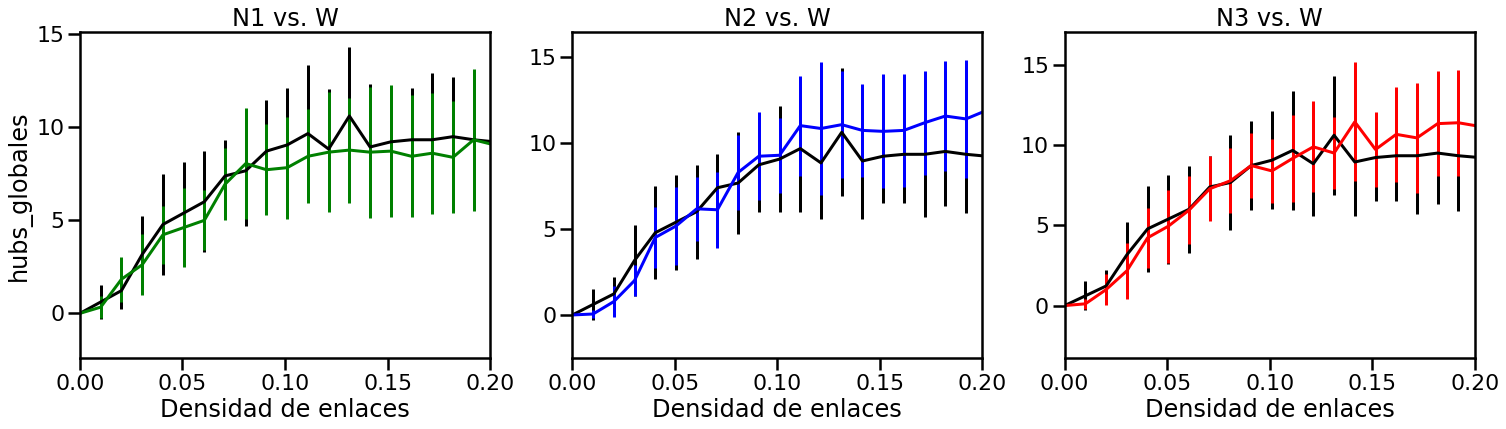

In [ ]:
variable = 'hubs_globales'
plt.figure(figsize=(25,6))
plt.subplot(1,3,1)
plt.errorbar(densities,df_stats.loc[df_stats.state == 'W',(variable,'mean')],df_stats.loc[df_stats.state == 'W',(variable,'std')],color="black",label="W");
plt.errorbar(densities,df_stats.loc[df_stats.state == 'N1',(variable,'mean')],df_stats.loc[df_stats.state == 'N1',(variable,'std')],color="green",label="N1");
plt.xlim(0, 0.2) 

plt.title("N1 vs. W")
plt.xlabel('Densidad de enlaces')
plt.ylabel(variable);

plt.subplot(1,3,2)
plt.errorbar(densities,df_stats.loc[df_stats.state == 'W',(variable,'mean')],df_stats.loc[df_stats.state == 'W',(variable,'std')],color="black",label="W");
plt.errorbar(densities,df_stats.loc[df_stats.state == 'N2',(variable,'mean')],df_stats.loc[df_stats.state == 'N2',(variable,'std')],color="blue",label="N2");
plt.xlim(0, 0.2) 
plt.title("N2 vs. W")
plt.xlabel('Densidad de enlaces')


plt.subplot(1,3,3)
plt.errorbar(densities,df_stats.loc[df_stats.state == 'W',(variable,'mean')],df_stats.loc[df_stats.state == 'W',(variable,'std')],color="black",label="W");
plt.errorbar(densities,df_stats.loc[df_stats.state == 'N3',(variable,'mean')],df_stats.loc[df_stats.state == 'N3',(variable,'std')],color="red",label="N3");
plt.xlim(0, 0.2) 
plt.title("N3 vs. W")
plt.xlabel('Densidad de enlaces')


Text(0.5, 0, 'Densidad de enlaces')

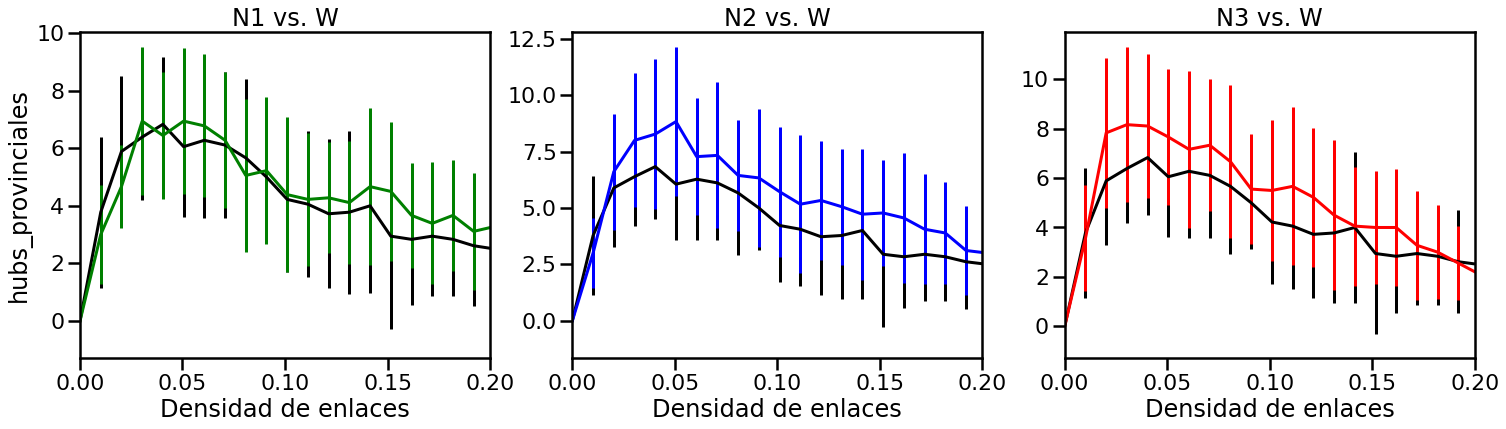

In [ ]:
variable = 'hubs_provinciales'
plt.figure(figsize=(25,6))
plt.subplot(1,3,1)
plt.errorbar(densities,df_stats.loc[df_stats.state == 'W',(variable,'mean')],df_stats.loc[df_stats.state == 'W',(variable,'std')],color="black",label="W");
plt.errorbar(densities,df_stats.loc[df_stats.state == 'N1',(variable,'mean')],df_stats.loc[df_stats.state == 'N1',(variable,'std')],color="green",label="N1");
plt.xlim(0, 0.2) 
plt.title("N1 vs. W")
plt.xlabel('Densidad de enlaces')
plt.ylabel(variable);

plt.subplot(1,3,2)
plt.errorbar(densities,df_stats.loc[df_stats.state == 'W',(variable,'mean')],df_stats.loc[df_stats.state == 'W',(variable,'std')],color="black",label="W");
plt.errorbar(densities,df_stats.loc[df_stats.state == 'N2',(variable,'mean')],df_stats.loc[df_stats.state == 'N2',(variable,'std')],color="blue",label="N2");
plt.xlim(0, 0.2) 
plt.title("N2 vs. W")
plt.xlabel('Densidad de enlaces')


plt.subplot(1,3,3)
plt.errorbar(densities,df_stats.loc[df_stats.state == 'W',(variable,'mean')],df_stats.loc[df_stats.state == 'W',(variable,'std')],color="black",label="W");
plt.errorbar(densities,df_stats.loc[df_stats.state == 'N3',(variable,'mean')],df_stats.loc[df_stats.state == 'N3',(variable,'std')],color="red",label="N3");
plt.xlim(0, 0.2) 
plt.title("N3 vs. W")
plt.xlabel('Densidad de enlaces')


Text(0.5, 0, 'Densidad de enlaces')

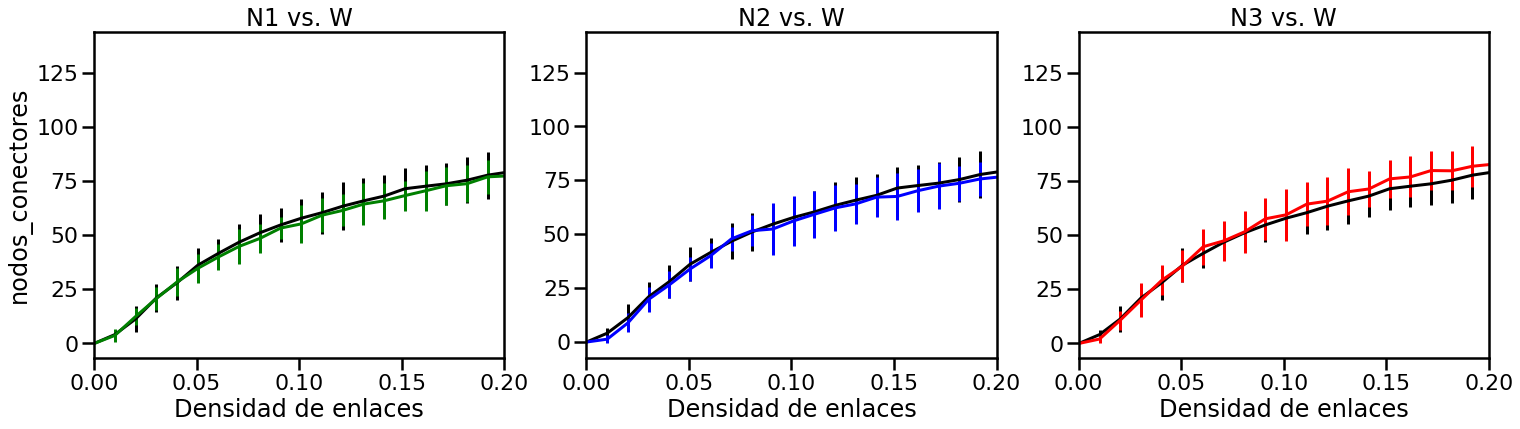

In [ ]:
variable = 'nodos_conectores'
plt.figure(figsize=(25,6))
plt.subplot(1,3,1)
plt.errorbar(densities,df_stats.loc[df_stats.state == 'W',(variable,'mean')],df_stats.loc[df_stats.state == 'W',(variable,'std')],color="black",label="W");
plt.errorbar(densities,df_stats.loc[df_stats.state == 'N1',(variable,'mean')],df_stats.loc[df_stats.state == 'N1',(variable,'std')],color="green",label="N1");
plt.xlim(0, 0.2) 
plt.title("N1 vs. W")
plt.xlabel('Densidad de enlaces')
plt.ylabel(variable);

plt.subplot(1,3,2)
plt.errorbar(densities,df_stats.loc[df_stats.state == 'W',(variable,'mean')],df_stats.loc[df_stats.state == 'W',(variable,'std')],color="black",label="W");
plt.errorbar(densities,df_stats.loc[df_stats.state == 'N2',(variable,'mean')],df_stats.loc[df_stats.state == 'N2',(variable,'std')],color="blue",label="N2");
plt.xlim(0, 0.2) 
plt.title("N2 vs. W")
plt.xlabel('Densidad de enlaces')


plt.subplot(1,3,3)
plt.errorbar(densities,df_stats.loc[df_stats.state == 'W',(variable,'mean')],df_stats.loc[df_stats.state == 'W',(variable,'std')],color="black",label="W");
plt.errorbar(densities,df_stats.loc[df_stats.state == 'N3',(variable,'mean')],df_stats.loc[df_stats.state == 'N3',(variable,'std')],color="red",label="N3");
plt.xlim(0, 0.2) 
plt.title("N3 vs. W")
plt.xlabel('Densidad de enlaces')


Text(0.5, 0, 'Densidad de enlaces')

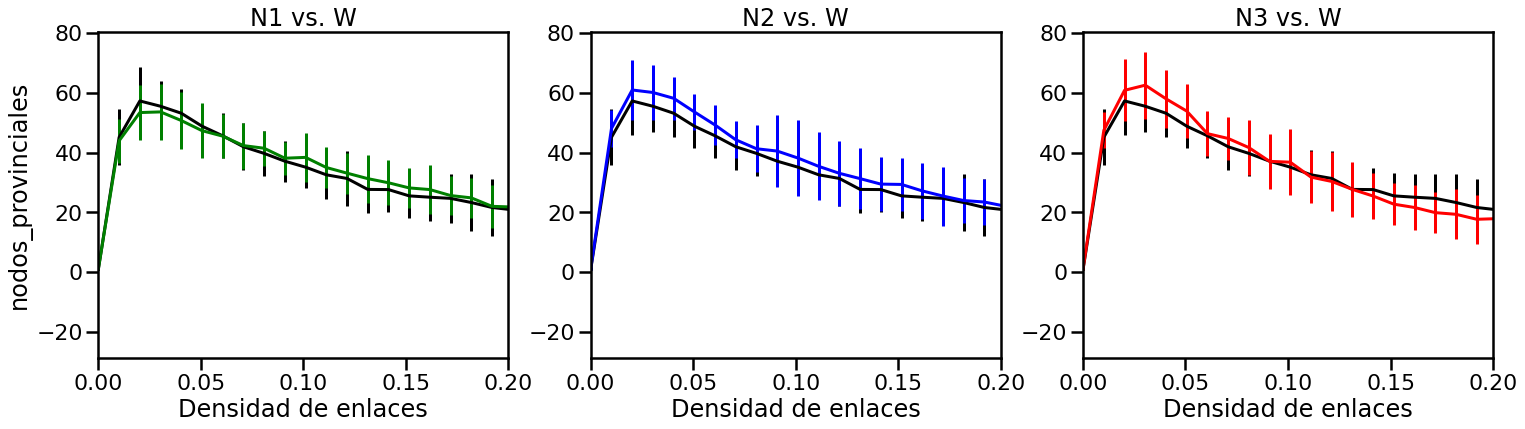

In [ ]:
variable = 'nodos_provinciales'
plt.figure(figsize=(25,6))
plt.subplot(1,3,1)
plt.errorbar(densities,df_stats.loc[df_stats.state == 'W',(variable,'mean')],df_stats.loc[df_stats.state == 'W',(variable,'std')],color="black",label="W");
plt.errorbar(densities,df_stats.loc[df_stats.state == 'N1',(variable,'mean')],df_stats.loc[df_stats.state == 'N1',(variable,'std')],color="green",label="N1");
plt.xlim(0, 0.2) 
plt.title("N1 vs. W")
plt.xlabel('Densidad de enlaces')
plt.ylabel(variable);

plt.subplot(1,3,2)
plt.errorbar(densities,df_stats.loc[df_stats.state == 'W',(variable,'mean')],df_stats.loc[df_stats.state == 'W',(variable,'std')],color="black",label="W");
plt.errorbar(densities,df_stats.loc[df_stats.state == 'N2',(variable,'mean')],df_stats.loc[df_stats.state == 'N2',(variable,'std')],color="blue",label="N2");
plt.xlim(0, 0.2) 
plt.title("N2 vs. W")
plt.xlabel('Densidad de enlaces')


plt.subplot(1,3,3)
plt.errorbar(densities,df_stats.loc[df_stats.state == 'W',(variable,'mean')],df_stats.loc[df_stats.state == 'W',(variable,'std')],color="black",label="W");
plt.errorbar(densities,df_stats.loc[df_stats.state == 'N3',(variable,'mean')],df_stats.loc[df_stats.state == 'N3',(variable,'std')],color="red",label="N3");
plt.xlim(0, 0.2) 
plt.title("N3 vs. W")
plt.xlabel('Densidad de enlaces')


Text(0.5, 0, 'Densidad de enlaces')

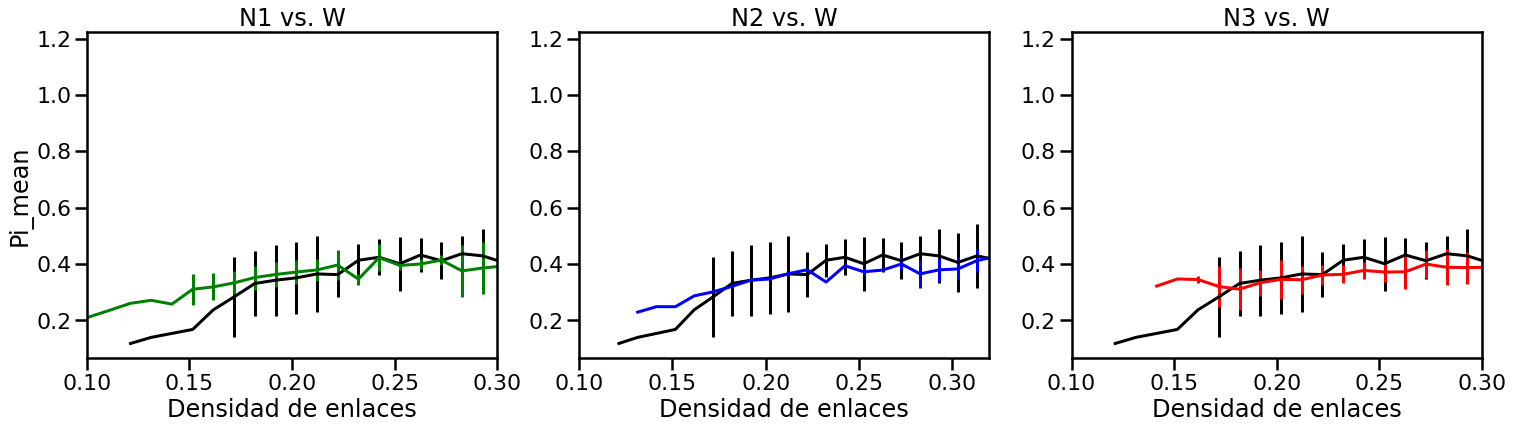

In [ ]:
variable = 'Pi_mean'
plt.figure(figsize=(25,6))
plt.subplot(1,3,1)
plt.errorbar(densities,df_stats.loc[df_stats.state == 'W',(variable,'mean')],df_stats.loc[df_stats.state == 'W',(variable,'std')],color="black",label="W");
plt.errorbar(densities,df_stats.loc[df_stats.state == 'N1',(variable,'mean')],df_stats.loc[df_stats.state == 'N1',(variable,'std')],color="green",label="N1");
plt.xlim(0.1, 0.3) 
plt.title("N1 vs. W")
plt.xlabel('Densidad de enlaces')
plt.ylabel(variable);

plt.subplot(1,3,2)
plt.errorbar(densities,df_stats.loc[df_stats.state == 'W',(variable,'mean')],df_stats.loc[df_stats.state == 'W',(variable,'std')],color="black",label="W");
plt.errorbar(densities,df_stats.loc[df_stats.state == 'N2',(variable,'mean')],df_stats.loc[df_stats.state == 'N2',(variable,'std')],color="blue",label="N2");
plt.xlim(0.1, 0.32) 
plt.title("N2 vs. W")
plt.xlabel('Densidad de enlaces')


plt.subplot(1,3,3)
plt.errorbar(densities,df_stats.loc[df_stats.state == 'W',(variable,'mean')],df_stats.loc[df_stats.state == 'W',(variable,'std')],color="black",label="W");
plt.errorbar(densities,df_stats.loc[df_stats.state == 'N3',(variable,'mean')],df_stats.loc[df_stats.state == 'N3',(variable,'std')],color="red",label="N3");
plt.xlim(0.1, 0.3) 
plt.title("N3 vs. W")
plt.xlabel('Densidad de enlaces')


Text(0.5, 0, 'Densidad de enlaces')

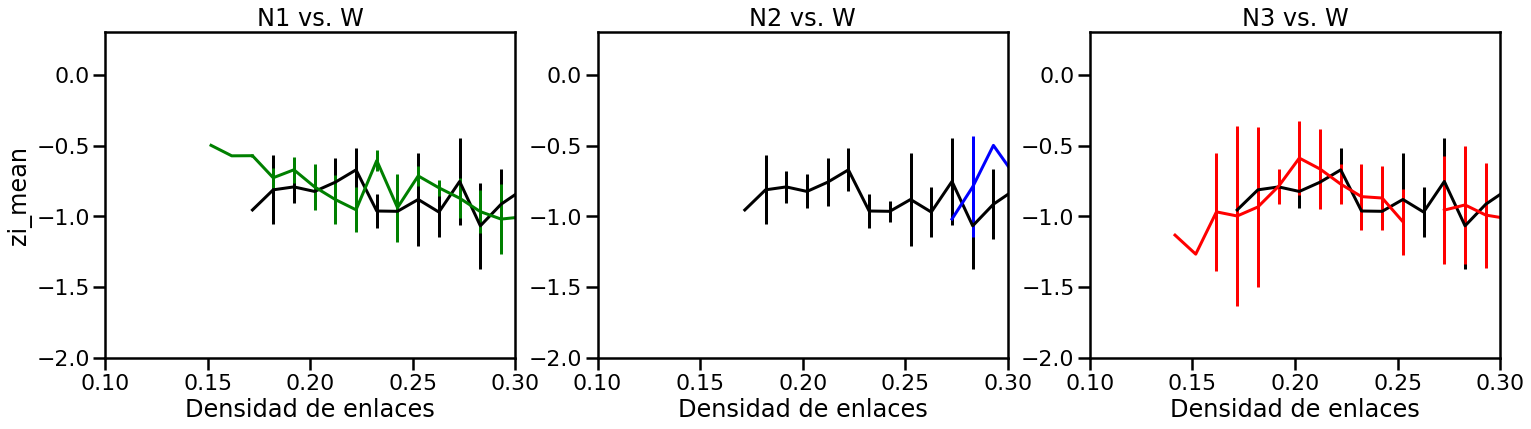

In [ ]:
variable = 'zi_mean'
plt.figure(figsize=(25,6))
plt.subplot(1,3,1)
plt.errorbar(densities,df_stats.loc[df_stats.state == 'W',(variable,'mean')],df_stats.loc[df_stats.state == 'W',(variable,'std')],color="black",label="W");
plt.errorbar(densities,df_stats.loc[df_stats.state == 'N1',(variable,'mean')],df_stats.loc[df_stats.state == 'N1',(variable,'std')],color="green",label="N1");
plt.xlim(0.1, 0.3) 
plt.ylim(-2, 0.3) 
plt.title("N1 vs. W")
plt.xlabel('Densidad de enlaces')
plt.ylabel(variable);

plt.subplot(1,3,2)
plt.errorbar(densities,df_stats.loc[df_stats.state == 'W',(variable,'mean')],df_stats.loc[df_stats.state == 'W',(variable,'std')],color="black",label="W");
plt.errorbar(densities,df_stats.loc[df_stats.state == 'N2',(variable,'mean')],df_stats.loc[df_stats.state == 'N2',(variable,'std')],color="blue",label="N2");
plt.xlim(0.1, 0.3) 
plt.ylim(-2, 0.3) 
plt.title("N2 vs. W")
plt.xlabel('Densidad de enlaces')


plt.subplot(1,3,3)
plt.errorbar(densities,df_stats.loc[df_stats.state == 'W',(variable,'mean')],df_stats.loc[df_stats.state == 'W',(variable,'std')],color="black",label="W");
plt.errorbar(densities,df_stats.loc[df_stats.state == 'N3',(variable,'mean')],df_stats.loc[df_stats.state == 'N3',(variable,'std')],color="red",label="N3");
plt.xlim(0.1, 0.3) 
plt.ylim(-2, 0.3) 
plt.title("N3 vs. W")
plt.xlabel('Densidad de enlaces')


In [ ]:
filenames_N1
file='DataSujetos/N1_suj2.csv'
correlation_matrix = pd.read_csv(filename, header=None)
n = correlation_matrix.shape[0]
correlation_matrix -= np.diag(np.ones(n))
max_links = (n*n-n)//2
tril_idx = np.tril_indices(n,-1)
sorted_correlations = sorted(correlation_matrix.values[tril_idx].flatten(),reverse=True)
    
Gs = []
densities=np.linspace(0.0001,0.3,20)    
for d in densities:
        idx = int(d*max_links)
        threshold = sorted_correlations[idx]
        Gs.append(nx.from_pandas_adjacency(correlation_matrix>=threshold))

<ipython-input-23-e306ead71b7e>:12: RuntimeWarning: invalid value encountered in double_scalars
  elem_sum += (KiUj_Ac[c][nodo]/grado_dict[nodo])* (KiUj_Ac[c][nodo]/grado_dict[nodo])
<ipython-input-21-00b42c9a45f3>:22: RuntimeWarning: divide by zero encountered in true_divide
  zi.append( ( ( kc[comunidad]-np.mean([x for x in kc[comunidad] if x > 0]) ) /np.std([x for x in kc[comunidad] if x > 0]) ) [nodo-1] )
<ipython-input-21-00b42c9a45f3>:22: RuntimeWarning: invalid value encountered in true_divide
  zi.append( ( ( kc[comunidad]-np.mean([x for x in kc[comunidad] if x > 0]) ) /np.std([x for x in kc[comunidad] if x > 0]) ) [nodo-1] )


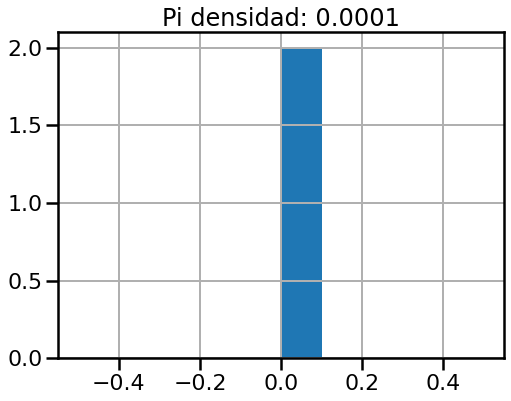

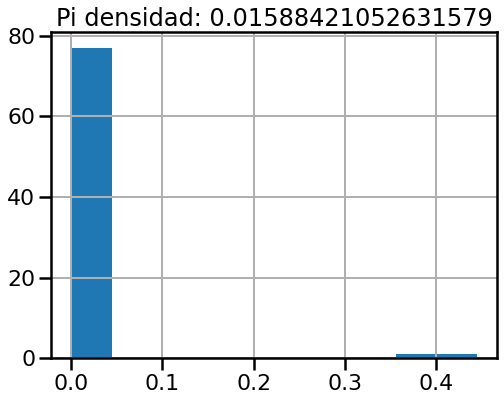

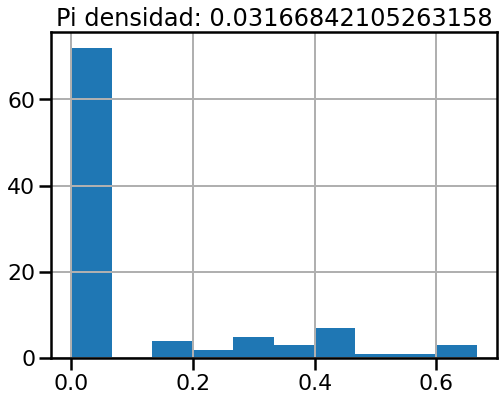

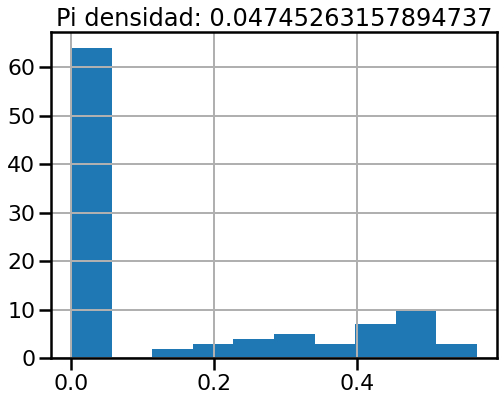

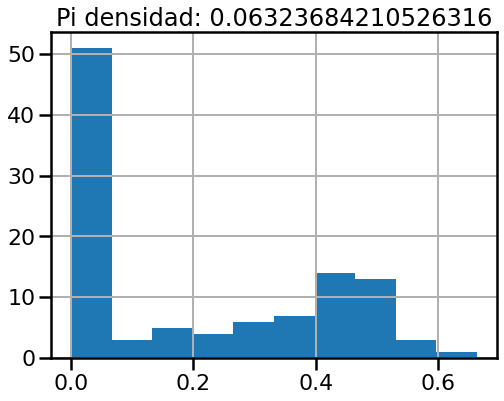

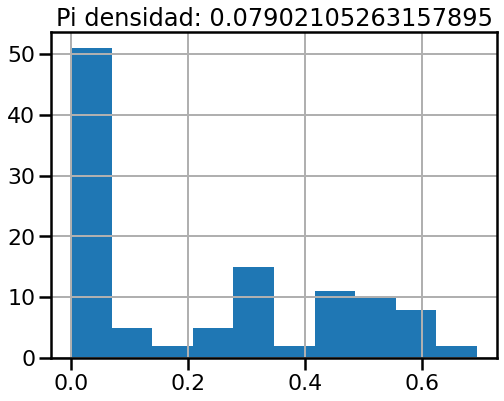

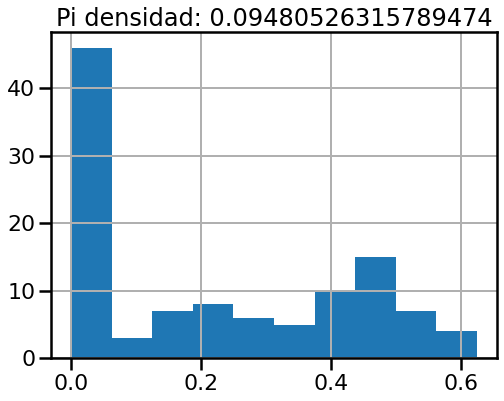

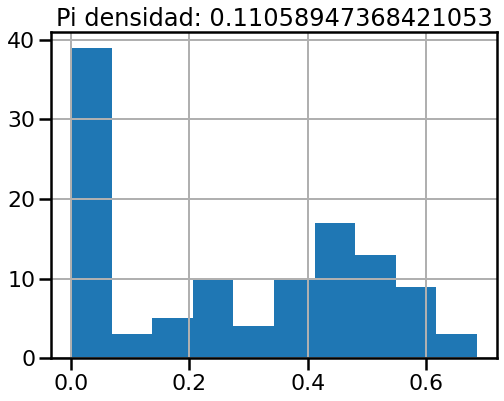

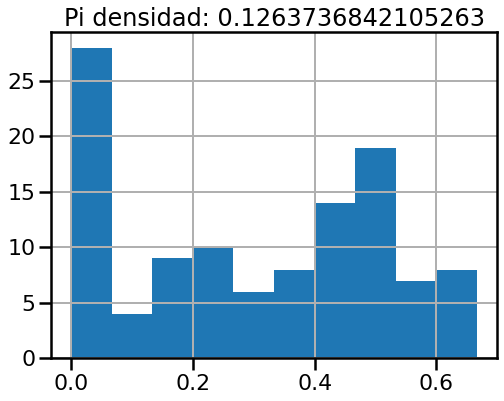

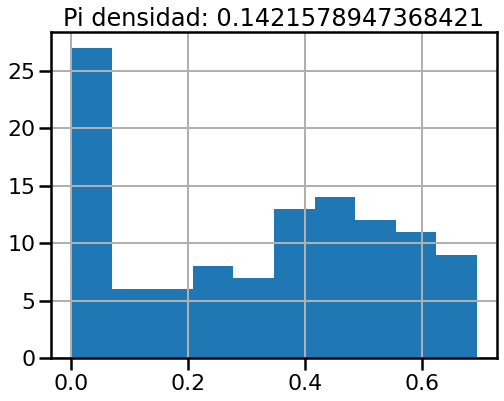

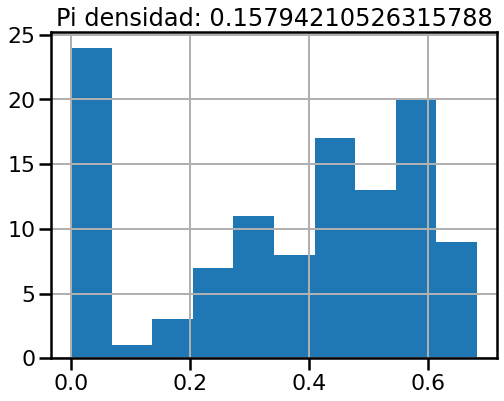

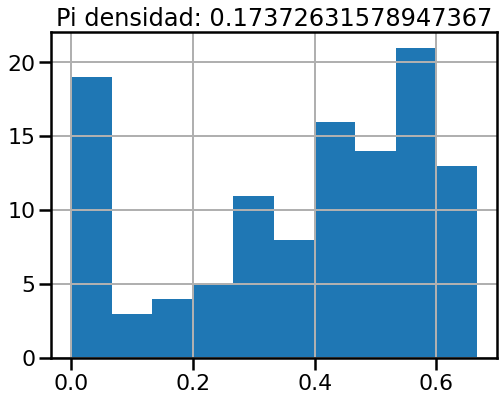

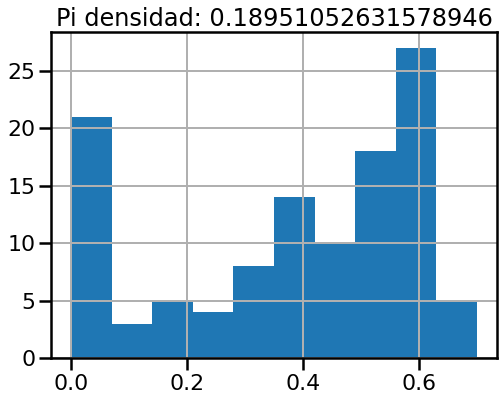

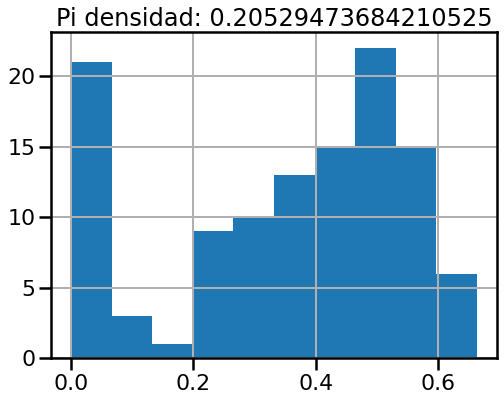

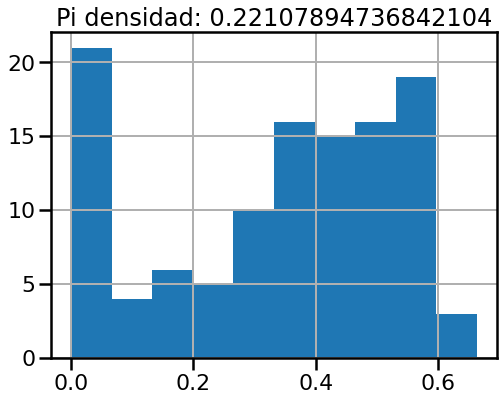

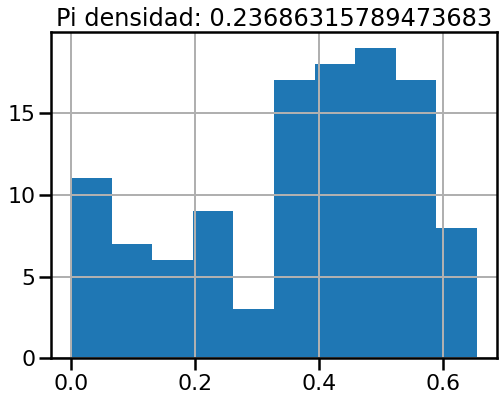

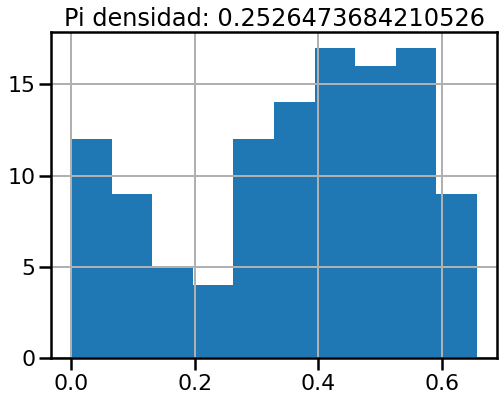

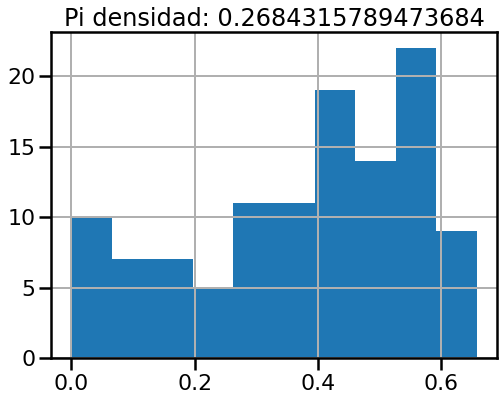

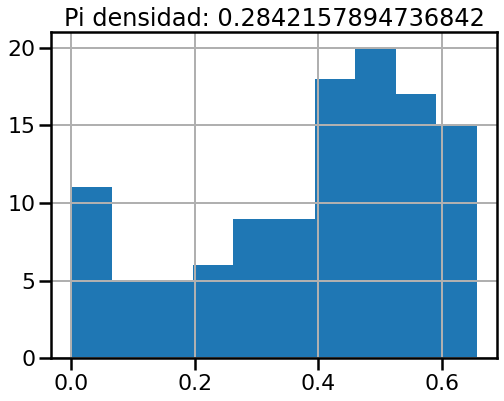

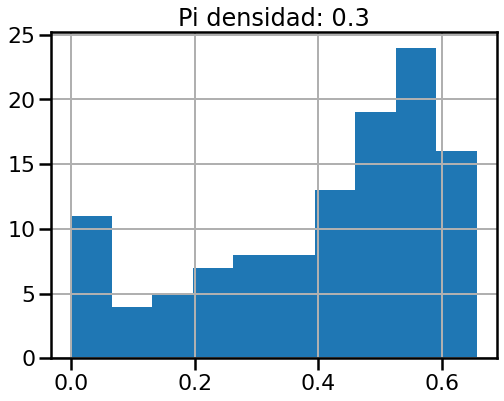

In [ ]:
for i,d in enumerate(densities):
      louvain_partition = community_louvain.best_partition(Gs[i]) #Gs[i] es el grafo de la densidad d no?
      Q = community_louvain.modularity(louvain_partition, Gs[i])
      Nc = max(louvain_partition.values()) + 1
      df=nx.to_pandas_adjacency(Gs[i])

      Pi_df=Pi(df,louvain_partition)
      zi_df=zi(df,louvain_partition)

      pd.DataFrame(Pi_df, columns=["Pi densidad: "+str(d)]).hist()

<ipython-input-23-e306ead71b7e>:12: RuntimeWarning: invalid value encountered in double_scalars
  elem_sum += (KiUj_Ac[c][nodo]/grado_dict[nodo])* (KiUj_Ac[c][nodo]/grado_dict[nodo])
<ipython-input-21-00b42c9a45f3>:22: RuntimeWarning: divide by zero encountered in true_divide
  zi.append( ( ( kc[comunidad]-np.mean([x for x in kc[comunidad] if x > 0]) ) /np.std([x for x in kc[comunidad] if x > 0]) ) [nodo-1] )
<ipython-input-21-00b42c9a45f3>:22: RuntimeWarning: invalid value encountered in true_divide
  zi.append( ( ( kc[comunidad]-np.mean([x for x in kc[comunidad] if x > 0]) ) /np.std([x for x in kc[comunidad] if x > 0]) ) [nodo-1] )


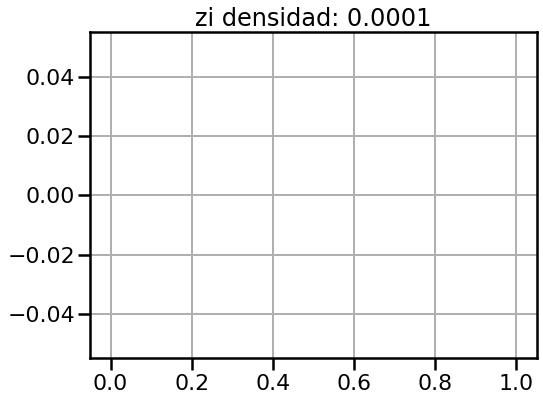

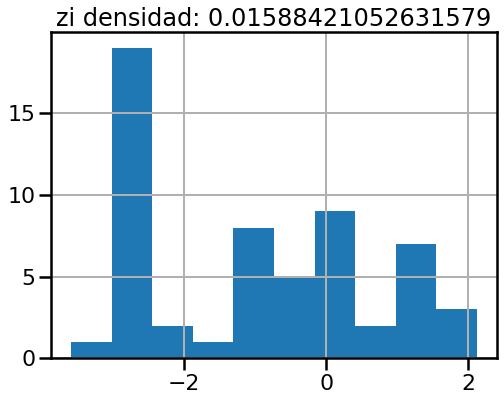

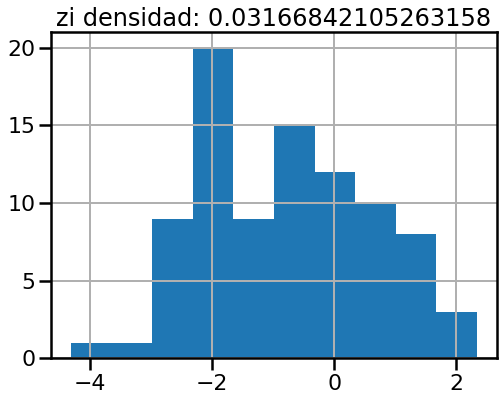

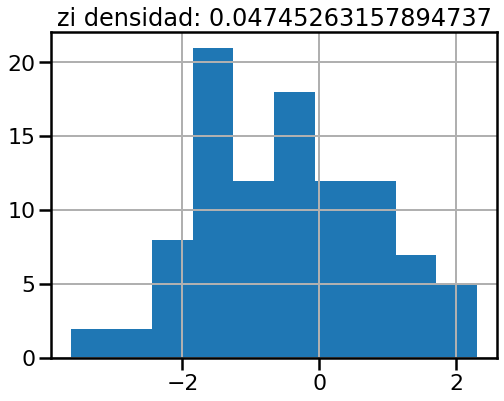

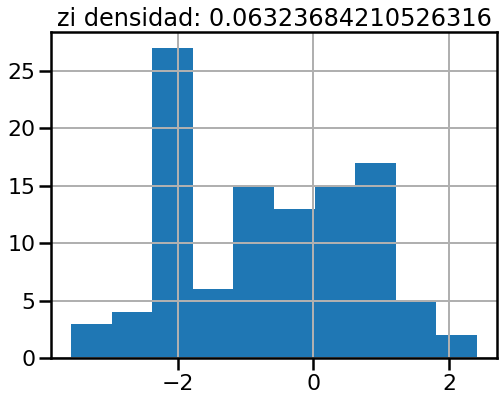

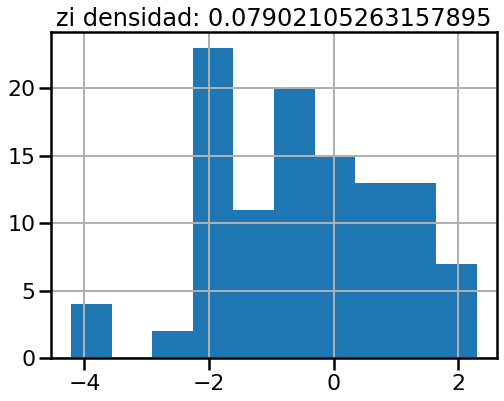

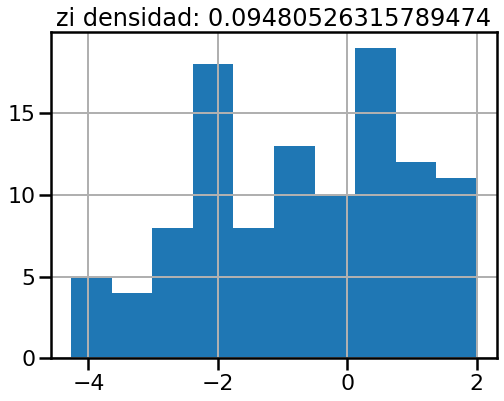

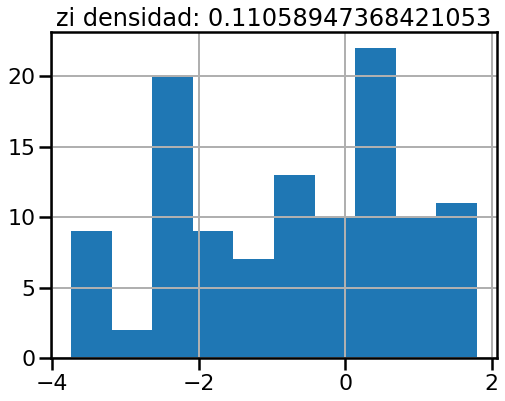

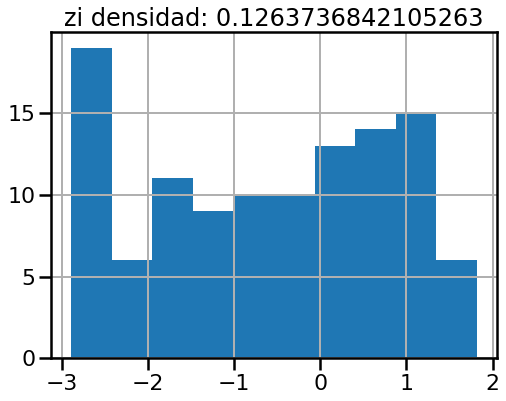

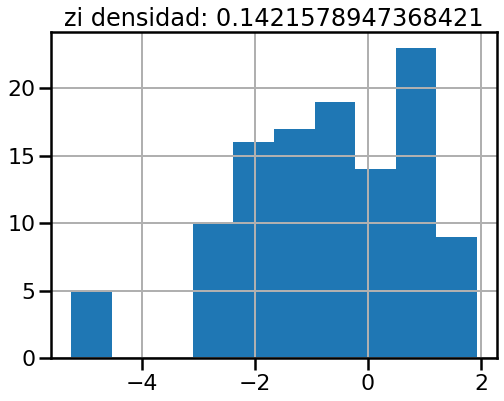

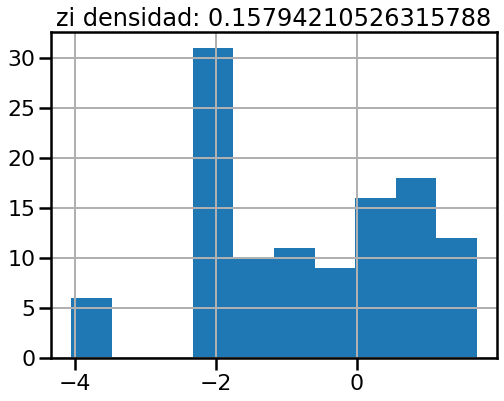

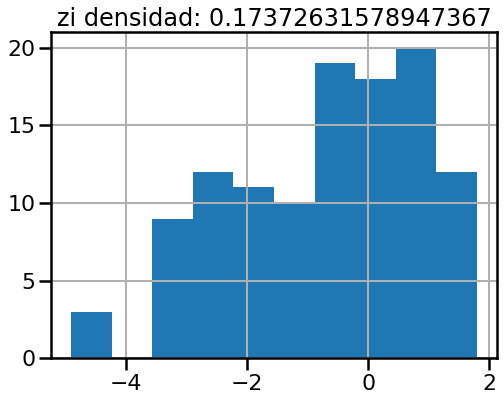

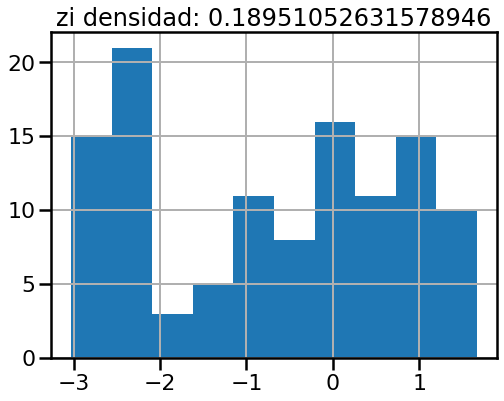

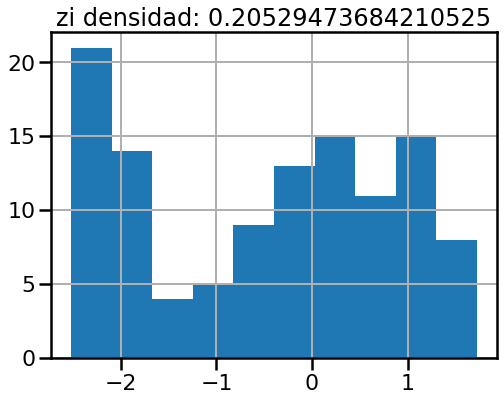

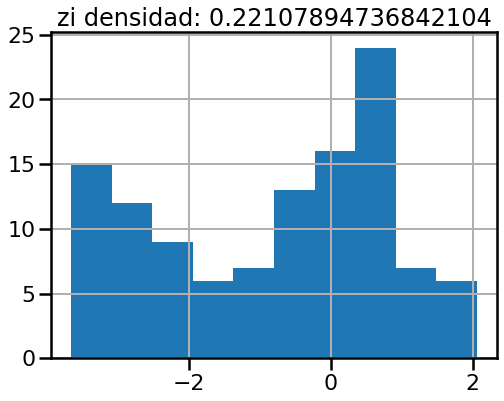

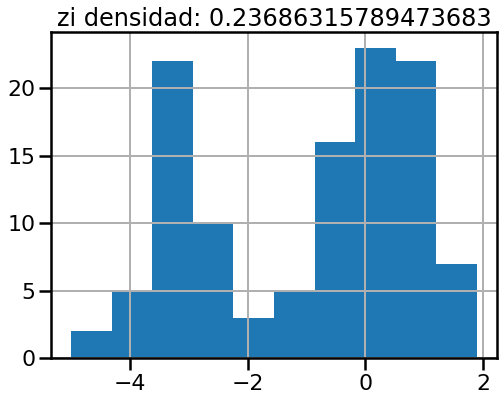

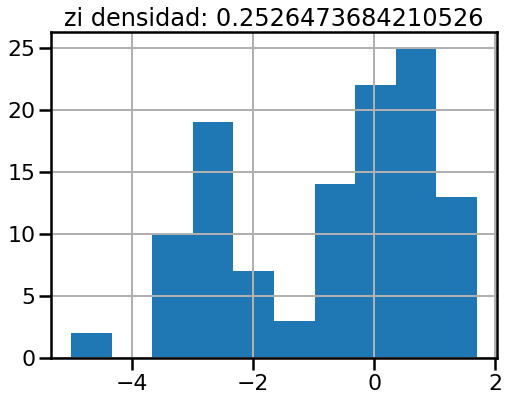

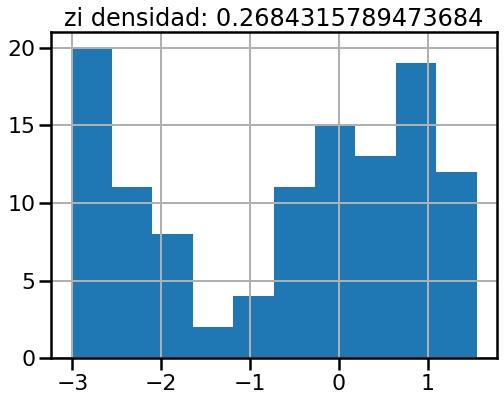

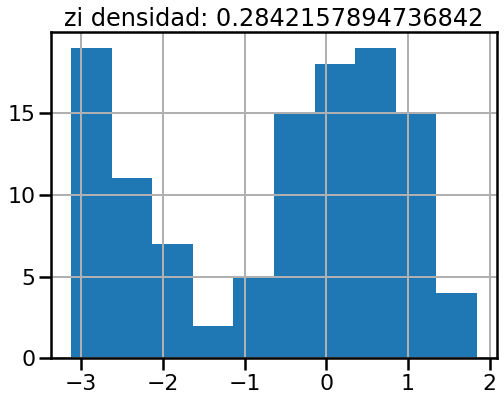

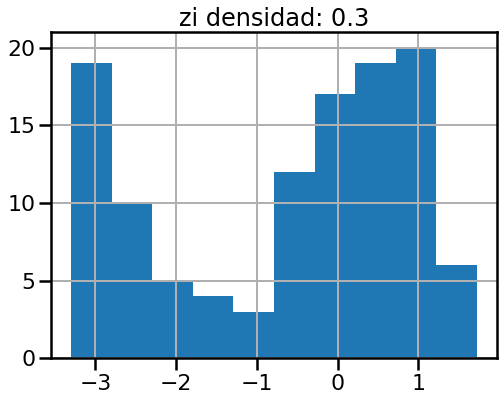

In [ ]:
for i,d in enumerate(densities):
      louvain_partition = community_louvain.best_partition(Gs[i]) #Gs[i] es el grafo de la densidad d no?
      Q = community_louvain.modularity(louvain_partition, Gs[i])
      Nc = max(louvain_partition.values()) + 1
      df=nx.to_pandas_adjacency(Gs[i])

      Pi_df=Pi(df,louvain_partition)
      zi_df=zi(df,louvain_partition)


      zi_pd=pd.DataFrame(zi_df, columns=["zi densidad: "+str(d)])
      zi_pd[zi_pd["zi densidad: "+str(d)]>-100].hist()

In [ ]:
for i,d in enumerate(densities):
      louvain_partition = community_louvain.best_partition(Gs[i]) #Gs[i] es el grafo de la densidad d no?
      Q = community_louvain.modularity(louvain_partition, Gs[i])
      Nc = max(louvain_partition.values()) + 1
      df=nx.to_pandas_adjacency(Gs[i])

      Pi_df=Pi(df,louvain_partition)
      zi_df=zi(df,louvain_partition)

      pd.DataFrame(Pi_df, columns=["Pi densidad: "+str(d)]).hist()

      zi_pd=pd.DataFrame(zi_df, columns=["zi densidad: "+str(d)])
      zi_pd[zi_pd["zi densidad: "+str(d)]>-100].hist()

<ipython-input-8-e306ead71b7e>:12: RuntimeWarning: invalid value encountered in double_scalars
  elem_sum += (KiUj_Ac[c][nodo]/grado_dict[nodo])* (KiUj_Ac[c][nodo]/grado_dict[nodo])
<ipython-input-6-00b42c9a45f3>:22: RuntimeWarning: divide by zero encountered in true_divide
  zi.append( ( ( kc[comunidad]-np.mean([x for x in kc[comunidad] if x > 0]) ) /np.std([x for x in kc[comunidad] if x > 0]) ) [nodo-1] )
<ipython-input-6-00b42c9a45f3>:22: RuntimeWarning: invalid value encountered in true_divide
  zi.append( ( ( kc[comunidad]-np.mean([x for x in kc[comunidad] if x > 0]) ) /np.std([x for x in kc[comunidad] if x > 0]) ) [nodo-1] )


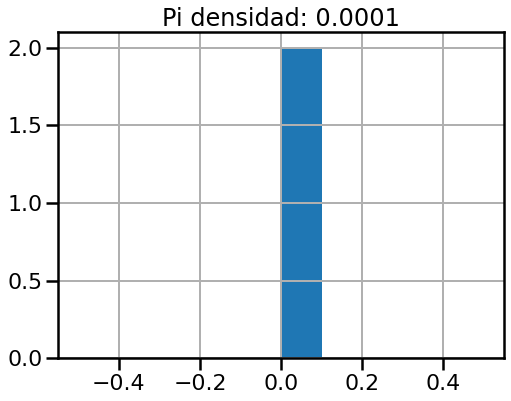

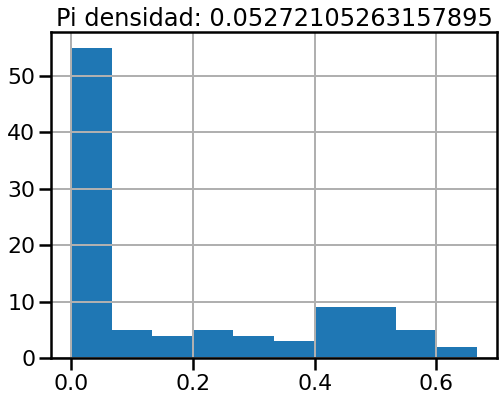

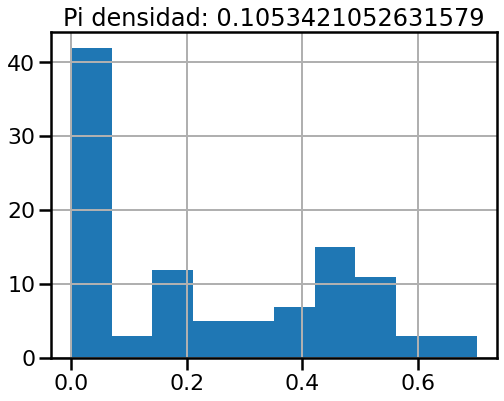

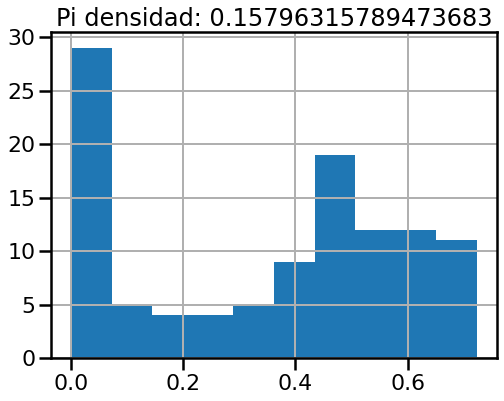

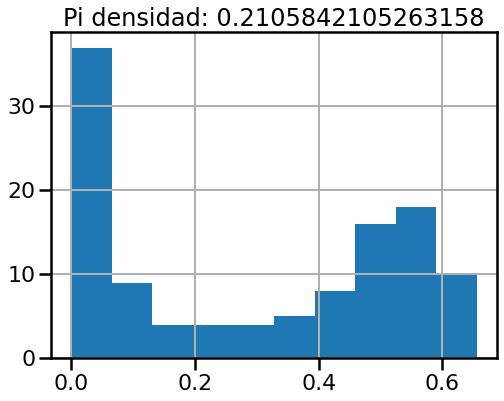

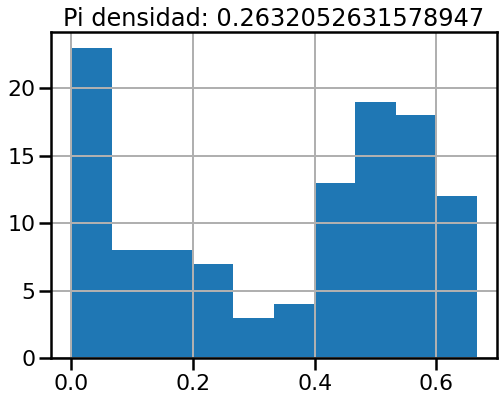

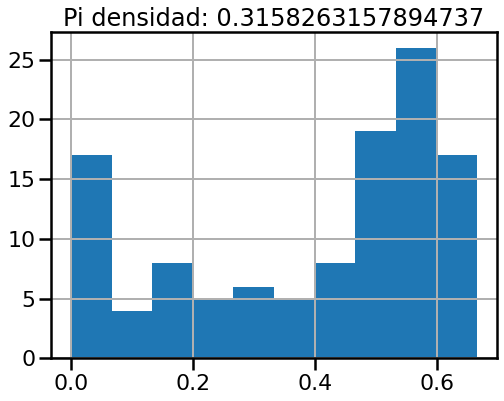

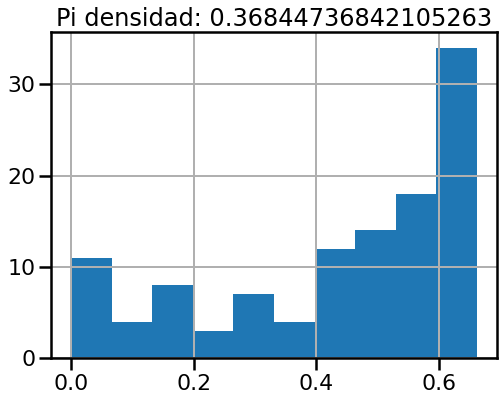

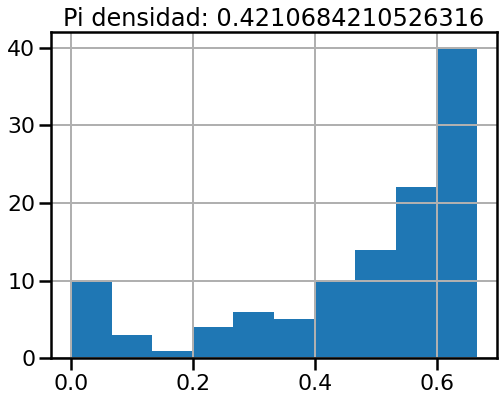

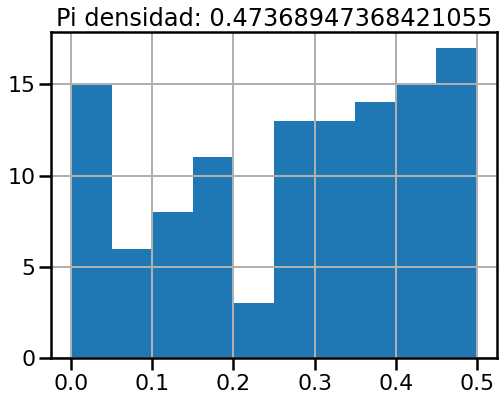

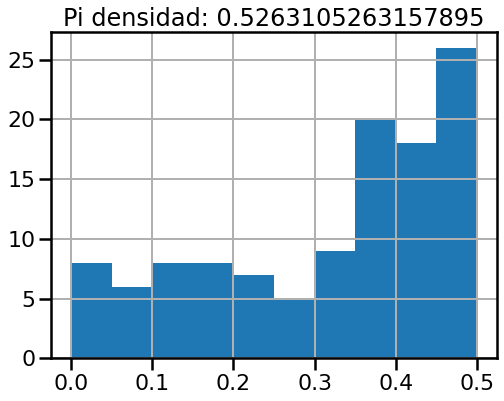

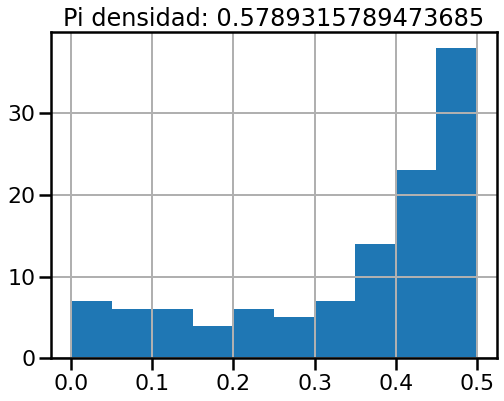

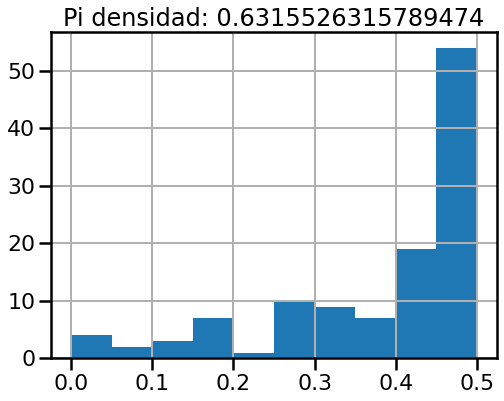

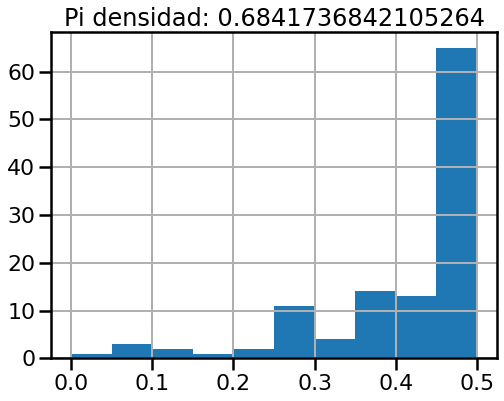

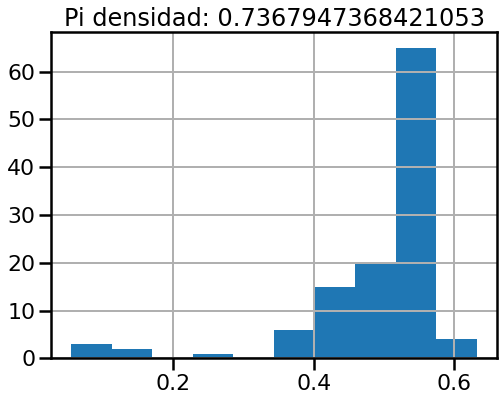

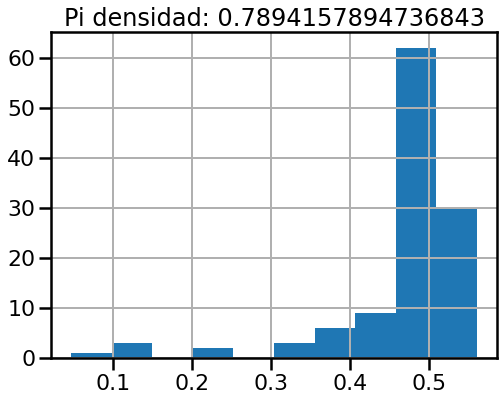

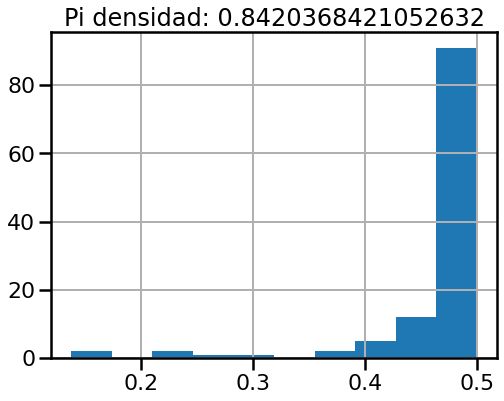

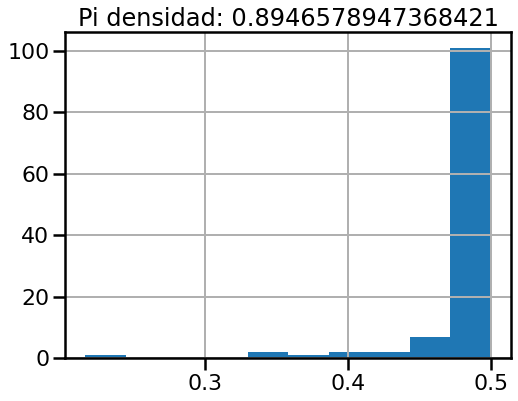

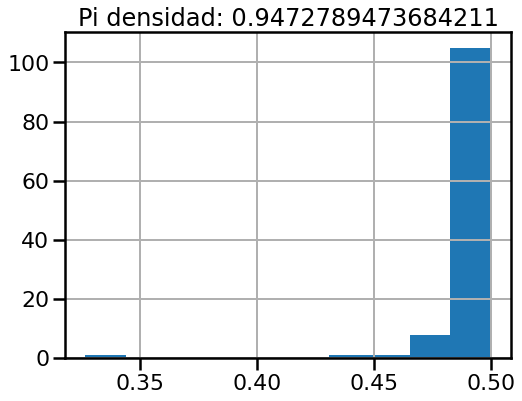

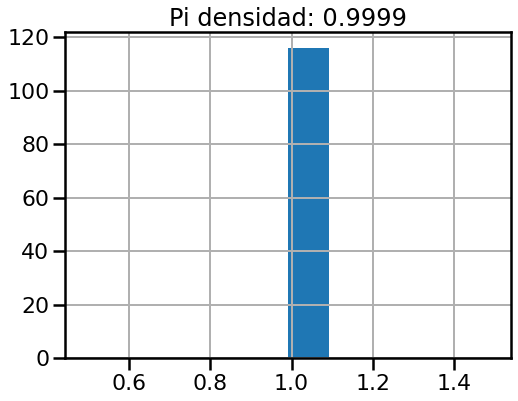

In [ ]:
for i,d in enumerate(densities):
      louvain_partition = community_louvain.best_partition(Gs[i]) #Gs[i] es el grafo de la densidad d no?
      Q = community_louvain.modularity(louvain_partition, Gs[i])
      Nc = max(louvain_partition.values()) + 1
      df=nx.to_pandas_adjacency(Gs[i])

      Pi_df=Pi(df,louvain_partition)
      zi_df=zi(df,louvain_partition)

      pd.DataFrame(Pi_df, columns=["Pi densidad: "+str(d)]).hist()


<ipython-input-8-e306ead71b7e>:12: RuntimeWarning: invalid value encountered in double_scalars
  elem_sum += (KiUj_Ac[c][nodo]/grado_dict[nodo])* (KiUj_Ac[c][nodo]/grado_dict[nodo])
<ipython-input-6-00b42c9a45f3>:22: RuntimeWarning: divide by zero encountered in true_divide
  zi.append( ( ( kc[comunidad]-np.mean([x for x in kc[comunidad] if x > 0]) ) /np.std([x for x in kc[comunidad] if x > 0]) ) [nodo-1] )
<ipython-input-6-00b42c9a45f3>:22: RuntimeWarning: invalid value encountered in true_divide
  zi.append( ( ( kc[comunidad]-np.mean([x for x in kc[comunidad] if x > 0]) ) /np.std([x for x in kc[comunidad] if x > 0]) ) [nodo-1] )


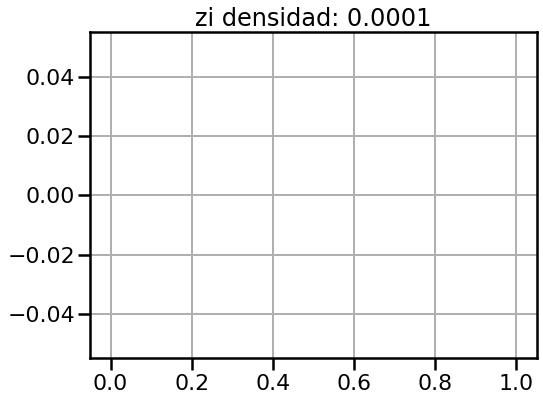

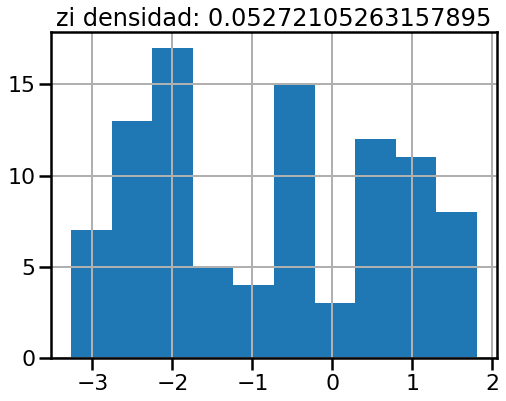

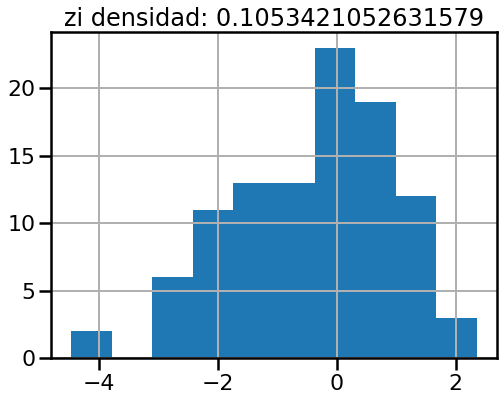

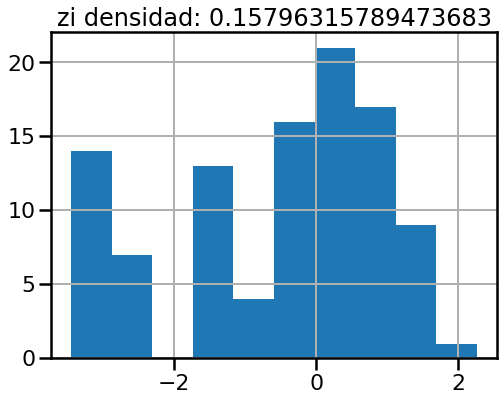

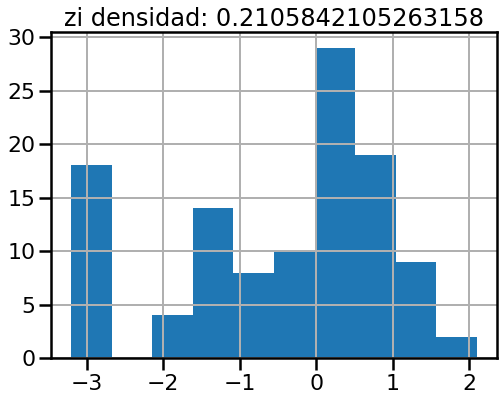

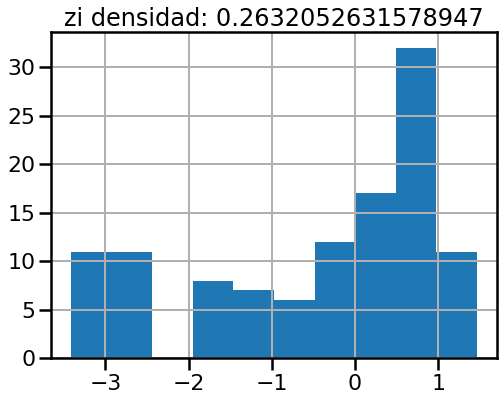

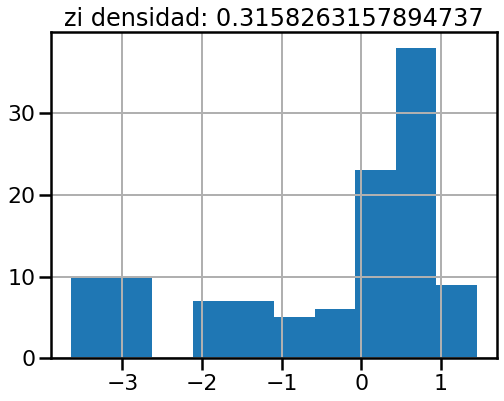

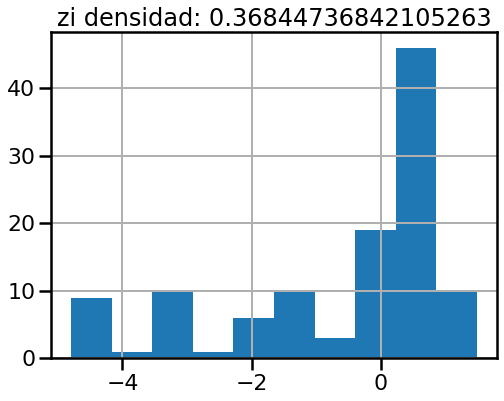

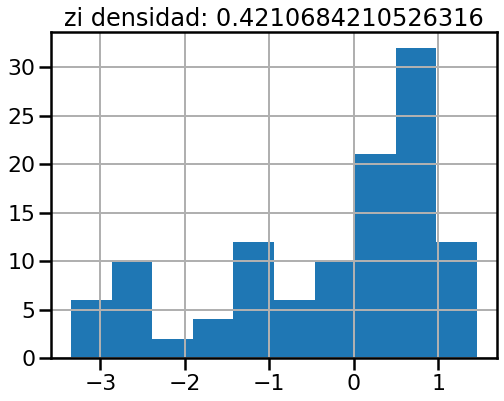

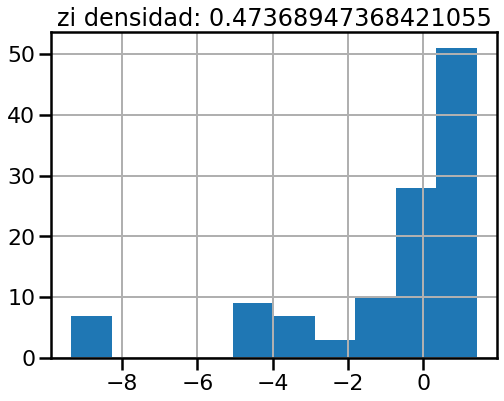

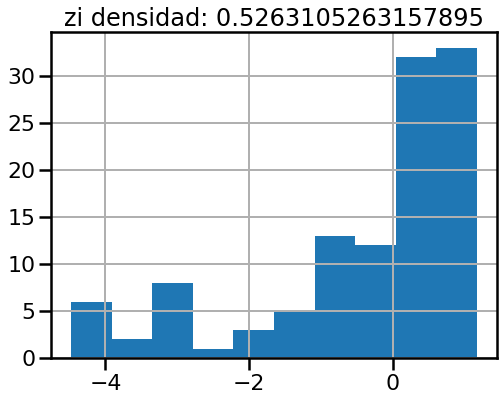

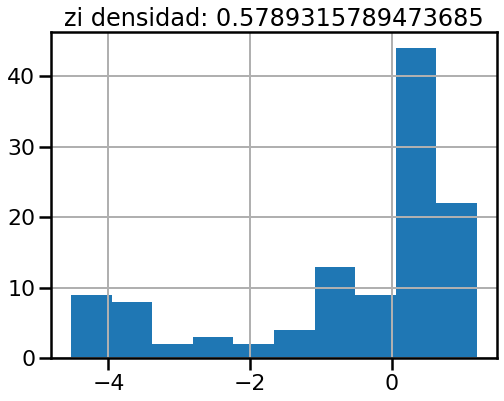

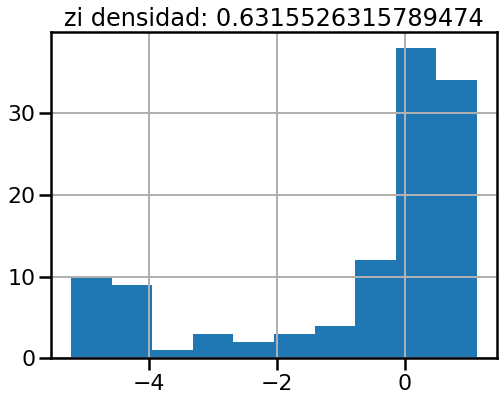

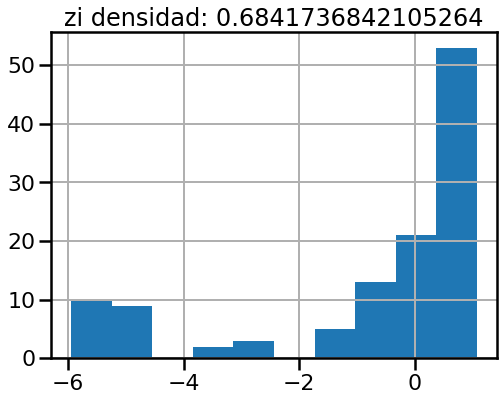

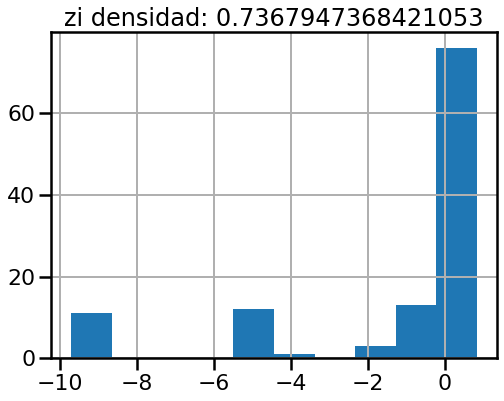

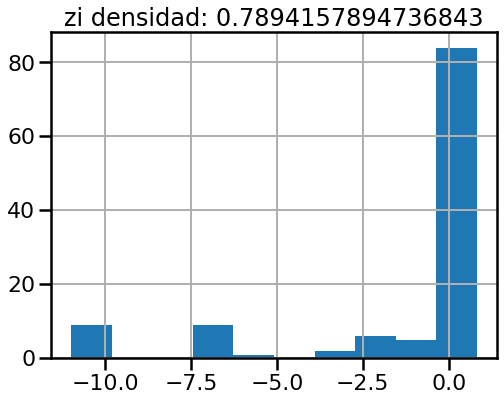

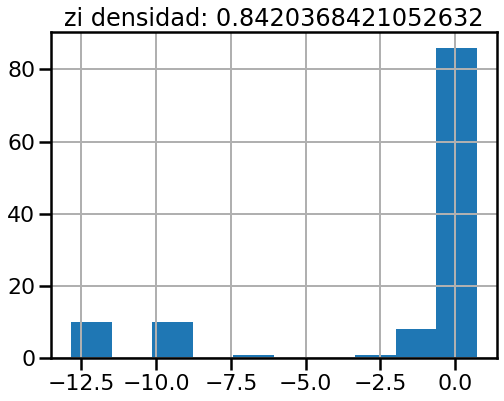

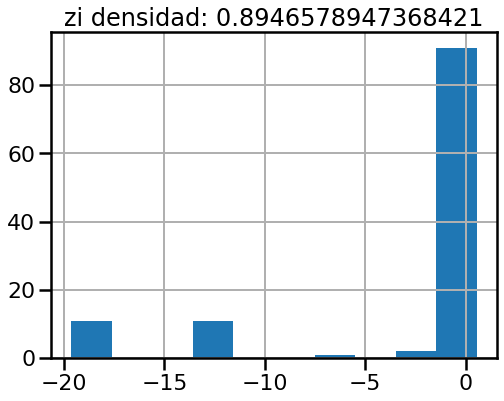

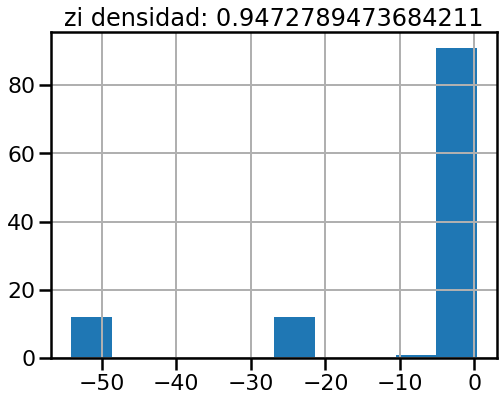

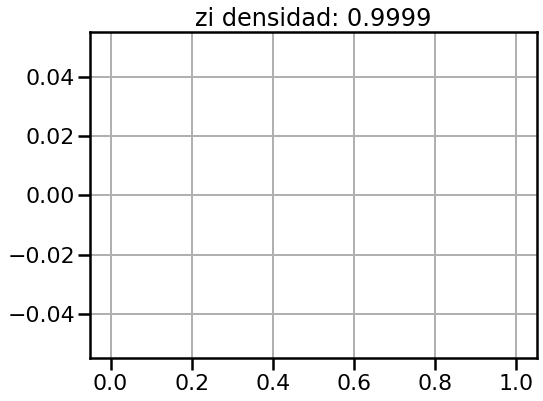

In [ ]:
for i,d in enumerate(densities):
      louvain_partition = community_louvain.best_partition(Gs[i]) #Gs[i] es el grafo de la densidad d no?
      Q = community_louvain.modularity(louvain_partition, Gs[i])
      Nc = max(louvain_partition.values()) + 1
      df=nx.to_pandas_adjacency(Gs[i])

      Pi_df=Pi(df,louvain_partition)
      zi_df=zi(df,louvain_partition)


      zi_pd=pd.DataFrame(zi_df, columns=["zi densidad: "+str(d)])
      zi_pd[zi_pd["zi densidad: "+str(d)]>-100].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1b47fac970>]],
      dtype=object)

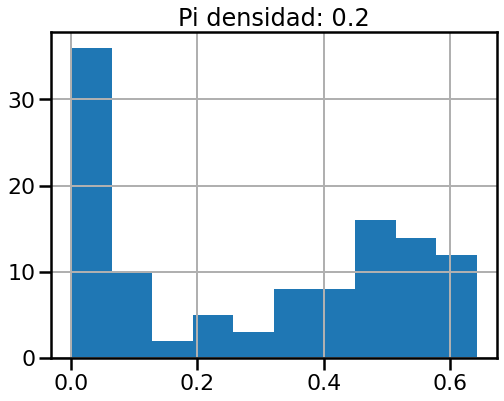

In [ ]:
pd.DataFrame(Pi_df, columns=["Pi densidad: "+str(d)]).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1b5d050a00>]],
      dtype=object)

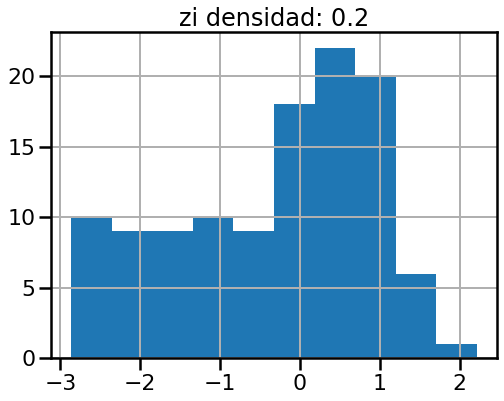

In [ ]:
      zi_pd=pd.DataFrame(zi_df, columns=["zi densidad: "+str(d)])
      zi_pd[zi_pd["zi densidad: "+str(d)]>-100].hist()

In [ ]:
zi_pd[~np.isnan(zi_df)].zi.min()

-inf

In [ ]:
#matriz de adyacencia
A = pd.DataFrame(np.array([[0,1,1,1,1,0,0],
              [1,0,1,0,0,1,1],
              [1,1,0,0,1,0,1],
              [1,0,0,0,0,0,0],
              [1,0,1,0,0,0,0],
              [0,1,0,0,0,0,1],
              [0,1,1,0,0,1,0]]) )
#diccionario con comunidades
c_dict = {1:1,2:2,3:1,4:1,5:3, 6:2, 7:2}

z-score del grado intra-comunidad (zi)

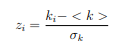

Donde: 

donde k
Uj
i
es el número de aristas en el nodo i y la comunidad j, NM es el número de
comunidades, y ki es el grado total del nodo i.


In [ ]:
#calcula el z-score de del grado intra-comunidad (zi) para cada nodo del grafo
def zi (df, c_dict):
  df=df.to_numpy()
  kc={}
  #"para cada comunidad i"
  for c in np.unique(list(c_dict.values())):
    nodo_pertenece_c= np.array(list(c_dict.values())) == c
    list_kc_row =[]
    for row in range(len(df)):
      row_elemi=[]
      if nodo_pertenece_c[row]:
        for col in range(len(df)):
          if nodo_pertenece_c[col]:
            #me quedo con elementos que pertenecen a la comunidad
            row_elemi.append(df[row,col]) 
      #calculo grado para ese elemento y lo guardo en una lista
      list_kc_row.append(sum(row_elemi))
    kc[c] = list_kc_row
          
  zi=[]
  for nodo,comunidad in c_dict.items():
    zi.append( ( ( kc[comunidad]-np.mean([x for x in k[comunidad] if x > 0]) ) /np.std([x for x in k[comunidad] if x > 0]) ) [nodo-1] )
  return zi

coeficiente de
participación (Pi) 

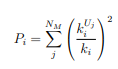

donde k
Uj
i
es el número de aristas en el nodo i y la comunidad j, NM es el número de
comunidades, y ki es el grado total del nodo i.


In [ ]:
#grado a módulo Uj, matriz
def KiUj(df,c_dict):
  #df=df.to_numpy()
  lkiUj = {}
  for i in np.unique(list(c_dict.values())):
    lkiUj[i] = list(np.matmul(df,np.array(list(c_dict.values())) == i) ) #no entiendo que hace esto, pero funciona
  return lkiUj

In [ ]:
#calcula el coeficiente de participación (Pi) para cada nodo del grafo
def Pi(df,c_dict):
  df=df.to_numpy()
  Pi=[]
  KiUj_Ac=KiUj(df,c_dict)
  G = nx.from_numpy_matrix(df)
  grado_dict=G.degree
  for nodo in range(len(df)):
    #voy sumando elementos elementos
    elem_sum=0
    for c in np.unique(list(c_dict.values())):
      elem_sum += (KiUj_Ac[c][nodo]/grado_dict[nodo])* (KiUj_Ac[c][nodo]/grado_dict[nodo])

    Pi.append(elem_sum)
  return(1-Pi)



In [ ]:
Pi(A,c_dict)

In [ ]:
densities = np.linspace(0.00001,.99999,50)

Pi_df=Pi(A,c_dict)
zi_df=zi(A,c_dict)

zc=1
Pc=0.05
#global hub (high z and high P) 
Hub_global = sum(np.multiply(np.array(zi_df) > zc , np.array(Pi_df) > Pc ) )
#provincial hub (high z and low P), 
Hub_provincial = sum(np.multiply(np.array(zi_df) > zc , np.array(Pi_df) < Pc ) )
#connector node (low z and high P), 
Nodo_conector = sum(np.multiply(np.array(zi_df) < zc , np.array(Pi_df) < Pc ) )
#provincial node (low z and low P)
Nodo_provincial = sum(np.multiply(np.array(zi_df) < zc , np.array(Pi_df) > Pc ) )



In [ ]:
pd.DataFrame(zi_df).hist()

In [ ]:
pd.DataFrame(Pi_df).hist()

In [ ]:
Hub_global

In [ ]:
Hub_provincial

In [ ]:
Nodo_conector

In [ ]:
Nodo_provincial